### Descargar librerias

In [1]:
#xd

### Importar librerias

In [2]:
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
from collections import deque
import math
import socket

### Probar uso de GPU con CUDA

In [3]:
print("Version TensorFlow:", tf.version.VERSION)

print("Compilado con CUDA?:", tf.test.is_built_with_cuda())

build_info = tf.sysconfig.get_build_info()
print("version CUDA:", build_info.get("cuda_version", "unknown"))
print("version cuDNN:", build_info.get("cudnn_version", "unknown"))

gpus = tf.config.list_physical_devices('GPU')
print("GPUs fisicas:", gpus)

Version TensorFlow: 2.10.1
Compilado con CUDA?: True
version CUDA: 64_112
version cuDNN: 64_8
GPUs fisicas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Add this new cell after the imports and before the environment definition

class DebugConfig:
    def __init__(self):
        self.enabled = False
        self.show_experience_analysis = False
        self.show_target_network_verification = False
        self.show_experience_replay_debug = False
        self.show_q_learning_verification = False
        self.show_connection_debug = False
        
    def configure(self):
        """Configure debugging options"""
        print("\n" + "="*50)
        print("DEBUG CONFIGURATION")
        print("="*50)
        
        while True:
            choice = input("\nEnable detailed debugging? (y/n): ").lower().strip()
            if choice in ['y', 'yes', 'n', 'no']:
                self.enabled = choice in ['y', 'yes']
                break
            print("Please enter 'y' for yes or 'n' for no.")
        
        if self.enabled:
            print("\nSelect debugging components to enable:")
            print("1. Experience quality analysis")
            print("2. Target network verification")
            print("3. Experience replay debugging")
            print("4. Q-learning verification")
            print("5. Connection debugging")
            print("6. Enable all")
            print("7. Disable all detailed debugging (keep only summaries)")
            
            while True:
                choices = input("\nEnter numbers separated by commas (e.g., 1,3,5): ").strip()
                if choices == "":
                    break
                
                try:
                    selected = [int(x.strip()) for x in choices.split(',')]
                    valid = all(1 <= x <= 7 for x in selected)
                    
                    if valid:
                        if 6 in selected:  # Enable all
                            self.show_experience_analysis = True
                            self.show_target_network_verification = True
                            self.show_experience_replay_debug = True
                            self.show_q_learning_verification = True
                            self.show_connection_debug = True
                        elif 7 in selected:  # Disable all
                            self.show_experience_analysis = False
                            self.show_target_network_verification = False
                            self.show_experience_replay_debug = False
                            self.show_q_learning_verification = False
                            self.show_connection_debug = False
                        else:
                            self.show_experience_analysis = 1 in selected
                            self.show_target_network_verification = 2 in selected
                            self.show_experience_replay_debug = 3 in selected
                            self.show_q_learning_verification = 4 in selected
                            self.show_connection_debug = 5 in selected
                        break
                    else:
                        print("Please enter valid numbers between 1 and 7.")
                except ValueError:
                    print("Please enter valid numbers separated by commas.")
        
        print(f"\nDebug Configuration:")
        print(f"  Main debugging: {'Enabled' if self.enabled else 'Disabled'}")
        if self.enabled:
            print(f"  Experience analysis: {'Enabled' if self.show_experience_analysis else 'Disabled'}")
            print(f"  Target network verification: {'Enabled' if self.show_target_network_verification else 'Disabled'}")
            print(f"  Experience replay debug: {'Enabled' if self.show_experience_replay_debug else 'Disabled'}")
            print(f"  Q-learning verification: {'Enabled' if self.show_q_learning_verification else 'Disabled'}")
            print(f"  Connection debugging: {'Enabled' if self.show_connection_debug else 'Disabled'}")
        print("  Episode summaries: Always enabled")
        print("  Final summary with graphs: Always enabled")

# Create global debug config
debug_config = DebugConfig()

### Definir environment de The Binding of Isaac

In [5]:
class IsaacEnv:
    def __init__(self, host='127.0.0.1', port=12345):
        self.num_actions = 11
        self.num_states = 37
        self.host = host
        self.port = port
        self.socket = None
        self.prev_state = []
        self.curr_state = []
        self.delay = 1/10000
        self.tries = 0
        self.connected = False
        self.connection_retry_count = 0
        self.max_retries = 3

    def connect(self):
        """Establish socket connection with improved error handling"""
        try:
            # Close any existing socket first
            if hasattr(self, 'socket') and self.socket:
                try:
                    self.socket.close()
                except:
                    pass
            if hasattr(self, 'conn') and self.conn:
                try:
                    self.conn.close()
                except:
                    pass
            
            self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            
            # Improved socket options
            self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            self.socket.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1)
            
            # Shorter timeout for initial connection
            self.socket.settimeout(10.0)  # Reduced from 30 to 10 seconds
            
            self.socket.bind((self.host, self.port))
            self.socket.listen(1)
            print(f"Python waiting for connection on {self.host}:{self.port}...")
            
            conn, addr = self.socket.accept()
            print(f"Connected to {addr}")

            # Set to blocking initially, then configure timeout
            conn.setblocking(True)
            conn.settimeout(3.0)  # 3 second timeout for data operations

            self.conn = conn
            self.connected = True
            self.connection_retry_count = 0  # Reset retry count on successful connection
            return True
        except Exception as e:
            print(f"Error establishing connection: {e}")
            self.connection_retry_count += 1
            # Clean up on failure
            if hasattr(self, 'socket') and self.socket:
                try:
                    self.socket.close()
                except:
                    pass
                self.socket = None
            return False
        
    def ensure_connection(self):
        """Ensure connection is alive, reconnect if needed"""
        if not self.connected or not self.test_connection_health():
            print("Connection lost, attempting to reconnect...")
            self.disconnect()
            
            # Wait a moment before reconnecting
            time.sleep(1)
            
            # Retry connection up to max_retries times
            for attempt in range(self.max_retries):
                print(f"Reconnection attempt {attempt + 1}/{self.max_retries}")
                if self.connect():
                    print("Reconnection successful!")
                    return True
                print(f"Reconnection attempt {attempt + 1} failed, waiting 2 seconds...")
                time.sleep(2)  # Wait between attempts
            
            print(f"Failed to reconnect after {self.max_retries} attempts")
            return False
        return True

    def disconnect(self):
        """Close socket connection safely"""
        try:
            if hasattr(self, 'conn') and self.conn:
                self.conn.close()
                self.conn = None
            if self.socket:
                self.socket.close()
                self.socket = None
            self.connected = False
            print("Socket connection closed")
        except Exception as e:
            print(f"Error closing connection: {e}")

    def is_connection_alive(self):
        """Test if connection is still alive"""
        if not self.connected or not hasattr(self, 'conn') or not self.conn:
            return False
        
        return self.test_connection_health()
        
    def parse_line(self, line: str, raw: bool = True):
        """
        Extrae los datos tras 'DATA:' y los organiza en un dict.
        """
        if 'DATA:' not in line:
            return []
        
        try:
            frame_part = line.split('FRAME:')[1].split('DATA:')[0].strip()
            frame_number = int(frame_part)

            _, raw_data = line.split('DATA:', 1)
            raw_data = raw_data.strip()
            parts = raw_data.split('|')

            if len(parts) != 40:
                raise ValueError(f"Esperaba 40 campos, encontré {len(parts)}")

            if raw:
                return [ # Convertir a float y int según corresponda
                    float(parts[i]) if i < 30 else
                    int(float(parts[i])) if i in (30, 32) else
                    float(parts[i]) if i < 33 else
                    bool(int(float(parts[i]))) if i <= 36 else
                    int(float(parts[i]))
                    for i in range(40)
                ]
        except Exception as e:
            print(f"Error parsing line: {e}")
            return []

    def receive_data(self):
        """Receive data from socket with improved error handling"""
        try:
            if not self.connected or not hasattr(self, 'conn') or not self.conn:
                return None
            
            # Use a reasonable timeout
            self.conn.settimeout(3.0)  # 3 second timeout
            data = self.conn.recv(4096).decode('utf-8')
            
            if not data:
                print("No data received, connection may be closed")
                self.connected = False
                return None
            
            return data.strip()
        except socket.timeout:
            # Normal timeout, don't disconnect immediately
            return None
        except (ConnectionResetError, BrokenPipeError, ConnectionAbortedError):
            print("Connection lost (reset/broken pipe/aborted)")
            self.connected = False
            return None
        except OSError as e:
            if e.errno == 10054:  # Windows connection reset error
                print("Connection forcibly closed by remote host")
                self.connected = False
            else:
                print(f"OS Error receiving data: {e}")
                self.connected = False
            return None
        except Exception as e:
            print(f"Error receiving data: {e}")
            # Only disconnect on serious errors, not timeouts
            if "timeout" not in str(e).lower():
                self.connected = False
            return None
        
    def test_connection_health(self):
        """Test if connection is responsive without sending empty bytes"""
        if not self.connected or not hasattr(self, 'conn') or not self.conn:
            return False
        
        try:
            # Check socket state without sending data
            error = self.conn.getsockopt(socket.SOL_SOCKET, socket.SO_ERROR)
            if error:
                print(f"Socket error detected: {error}")
                return False
            return True
        except Exception as e:
            print(f"Connection health check failed: {e}")
            return False

    def send_action(self, mov_left_right, mov_up_down, shoot_direction):
        """Send action to socket with retry logic"""
        max_send_retries = 3
        
        for attempt in range(max_send_retries):
            try:
                if not self.connected:
                    # Try to reconnect
                    if not self.ensure_connection():
                        return False
                
                action_str = f"{mov_left_right},{mov_up_down},{shoot_direction}\n"
                self.conn.sendall(action_str.encode('utf-8'))
                return True
                
            except (ConnectionResetError, BrokenPipeError):
                print(f"Connection lost during send (attempt {attempt + 1})")
                self.connected = False
                if attempt < max_send_retries - 1:
                    # Try to reconnect for next attempt
                    time.sleep(0.5)
                    self.ensure_connection()
            except Exception as e:
                print(f"Error sending action (attempt {attempt + 1}): {e}")
                if attempt < max_send_retries - 1:
                    time.sleep(0.1)
        
        return False

    def reset(self):
        """Reset environment with connection management"""
        # Ensure we have a good connection before starting
        if not self.ensure_connection():
            raise ConnectionError("Failed to establish socket connection")

        while True:
            self.tries += 1
            
            # Check connection health periodically
            if self.tries % 100 == 0:  # Every 100 tries
                if not self.ensure_connection():
                    raise ConnectionError("Lost connection during reset")
            
            line = self.receive_data()
            if not line:
                time.sleep(self.delay)
                continue
            
            try:
                data = self.parse_line(line)
                if len(data) == 0:
                    continue
                if data[30] == 0:  # Wait for valid player health
                    continue
                self.tries = 0
                return data
            except ValueError as e:
                print(f"Error parseando línea: {e}")

    def step(self):
        """Step environment with connection management"""
        while True:
            self.tries += 1
            
            # Check connection health periodically
            if self.tries % 100 == 0:  # Every 100 tries
                if not self.ensure_connection():
                    print("Connection lost during step, attempting to reconnect...")
                    time.sleep(1)
                    continue
            
            line = self.receive_data()
            if not line:
                time.sleep(self.delay)
                continue
            
            try:
                data = self.parse_line(line)
                if data:
                    self.tries = 0
                    return data
            except ValueError as e:
                print(f"Error parseando línea: {e}")

# Update environment initialization
env = IsaacEnv('127.0.0.1', 12345)

### Construcción de la red neuronal
el estado que recibe la red neuronal es un arreglo, donde cada posicion corresponde a las siguientes caracteristicas del estado:
0. float que corresponde a la posicion en x de una lagrima del jugador
1. float que corresponde a la posicion en y de una lagrima del jugador
2. float que corresponde a la velocidad en x de una lagrima del jugador
3. float que corresponde a la velocidad en y de una lagrima del jugador
4. float que corresponde a la posicion en x de una lagrima del jugador
5. float que corresponde a la posicion en y de una lagrima del jugador
6. float que corresponde a la velocidad en x de una lagrima del jugador
7. float que corresponde a la velocidad en y de una lagrima del jugador
8. float que corresponde a la posicion en x de una lagrima del jugador
9. float que corresponde a la posicion en y de una lagrima del jugador
10. float que corresponde a la velocidad en x de una lagrima del jugador
11. float que corresponde a la velocidad en y de una lagrima del jugador
12. float que corresponde a la posicion en x de una bala de un enemigo
13. float que corresponde a la posicion en y de una bala de un enemigo
14. float que corresponde a la velocidad en x de una bala de un enemigo
15. float que corresponde a la velocidad en y de una bala de un enemigo
16. float que corresponde a la posicion en x de una bala de un enemigo
17. float que corresponde a la posicion en y de una bala de un enemigo
18. float que corresponde a la velocidad en x de una bala de un enemigo
19. float que corresponde a la velocidad en y de una bala de un enemigo
20. float que corresponde a la posicion en x de una bala de un enemigo
21. float que corresponde a la posicion en y de una bala de un enemigo
22. float que corresponde a la velocidad en x de una bala de un enemigo
23. float que corresponde a la velocidad en y de una bala de un enemigo
24. float que corresponde a la posicion en x de un enemigo
25. float que corresponde a la posicion en y de un enemigo
26. float que corresponde a la posicion en x de un enemigo
27. float que corresponde a la posicion en y de un enemigo
28. float que corresponde a la posicion en x del jugador
29. float que corresponde a la posicion en y del jugador
30. entero que corresponde a la vida del jugador
31. entero que corresponde a la suma de las vidas actual de los enemigos
32. entero que corresponde al id de la sala actual
33. booleano que indica si se ha completado la primera sala
34. booleano que indica si se ha completado la segunda sala
35. booleano que indica si se ha completado la tercera sala
36. booleano que indica si se ha completado la cuarta sala

11 salidas, agrupadas en 3 grupos

grupo 1:
n1: no moverse
n2: moverse al izquierda
n3: moverse a la derecha

grupo 2:
n4: no moverse
n5: moverse a arriba
n6: moverse a abajo

grupo 3:
n7: no disparar
n8: disparar hacia arriba
n9: disparar hacia abajo
n10: disparar hacia derecha
n11: disparar hacia izquierda

In [6]:
# Replace the existing build_q_network function
tf.random.set_seed(8)
np.random.seed(8)
random.seed(8)

def build_q_network():
    """
    Multi-head network with separate outputs for each action group:
    - Head 1: Movement left/right (3 actions)
    - Head 2: Movement up/down (3 actions) 
    - Head 3: Shooting direction (5 actions)
    """
    inputs = tf.keras.layers.Input(shape=[env.num_states])
    
    # Shared layers
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    shared = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # Separate heads for each action type
    mov_lr_head = tf.keras.layers.Dense(32, activation='relu')(shared)
    mov_lr_output = tf.keras.layers.Dense(3, activation='linear', name='mov_lr')(mov_lr_head)
    
    mov_ud_head = tf.keras.layers.Dense(32, activation='relu')(shared)
    mov_ud_output = tf.keras.layers.Dense(3, activation='linear', name='mov_ud')(mov_ud_head)
    
    shoot_head = tf.keras.layers.Dense(32, activation='relu')(shared)
    shoot_output = tf.keras.layers.Dense(5, activation='linear', name='shoot')(shoot_head)
    
    model = tf.keras.Model(inputs=inputs, outputs=[mov_lr_output, mov_ud_output, shoot_output])
    return model

learning_rate = 0.001
q_network = build_q_network()
q_target_network = build_q_network()
q_target_network.set_weights(q_network.get_weights())
optimizer = tf.keras.optimizers.Adam(learning_rate)
q_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           2432        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

### Función epsilon greedy para exploración o explotación

In [7]:
# Replace the epsilon_greedy function
def epsilon_greedy(state, epsilon, q_network):
    """
    Returns action indices for each action group
    """
    if np.random.rand() < epsilon:
        # Random actions for each group
        mov_lr = random.randint(0, 2)      # 0: no move, 1: left, 2: right
        mov_ud = random.randint(0, 2)      # 0: no move, 1: up, 2: down  
        shoot = random.randint(0, 4)       # 0: no shoot, 1: up, 2: down, 3: right, 4: left
        return [mov_lr, mov_ud, shoot]
    else:
        q_values = q_network(state)
        mov_lr = tf.argmax(q_values[0][0]).numpy()
        mov_ud = tf.argmax(q_values[1][0]).numpy() 
        shoot = tf.argmax(q_values[2][0]).numpy()
        return [mov_lr, mov_ud, shoot]

### Función para determinar movimiento y disparo

In [8]:
# Update the get_mov_shoot_actions function
def get_mov_shoot_actions(action):
    """
    Action is now a list of 3 indices [mov_lr, mov_ud, shoot]
    """
    mov_left_right = action[0]
    mov_up_down = action[1] 
    shoot_direction = action[2]
    return mov_left_right, mov_up_down, shoot_direction

### Actualización de parámetros de la red neuronal (Pesos)

In [ ]:
# Replace the update_parameters function
def update_parameters(states, q_targets_lr, q_targets_ud, q_targets_shoot, q_network, optimizer):
    """
    Update parameters for multi-head network
    """
    with tf.GradientTape() as tape:
        q_values = q_network(states, training=True)
        
        # Calculate loss for each head
        loss_lr = tf.keras.losses.MeanSquaredError()(q_targets_lr, q_values[0])
        loss_ud = tf.keras.losses.MeanSquaredError()(q_targets_ud, q_values[1])
        loss_shoot = tf.keras.losses.MeanSquaredError()(q_targets_shoot, q_values[2])
        
        # Total loss
        total_loss = loss_lr + loss_ud + loss_shoot
        
    gradients = tape.gradient(total_loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    return total_loss

### Utilidades y funcion de recompensa

In [10]:
balas = []
def distancia_trayectoria(x0, y0, vx0, vy0, x_target, y_target):
    """Calcula la distancia mínima entre un punto (x_target, y_target) y una trayectoria lineal definida por posición (x0, y0) y velocidad (vx0, vy0)."""
    """
    """
    if vx0 == 0 and vy0 == 0:
        # Si no hay movimiento, calcula distancia euclidiana
        return math.sqrt((x0 - x_target)**2 + (y0 - y_target)**2)

    if vx0 != 0:
        # Caso no vertical: y = mx + b
        # 0 = mx + b - y
        m = vy0 / vx0
        b = y0 - m * x0
        dist_lagrima_enemigo = abs(m * x_target - y_target + b) / math.sqrt(m**2 + 1)
        pos_x_mas_cercana_al_enemigo, pos_y_mas_cercana_al_enemigo = posicion_de_la_recta_mas_cercana_al_enemigo(m, -1, b, x_target, y_target)
    else:
        # Caso vertical: x = constante
        dist_lagrima_enemigo = abs(x_target - x0)
        pos_x_mas_cercana_al_enemigo = x0
        if (vy0 < 0 and y_target <= y0) or (vy0 > 0 and y_target >= y0):
            pos_y_mas_cercana_al_enemigo = y_target
        else:
            pos_y_mas_cercana_al_enemigo = y0


    return dist_lagrima_enemigo, pos_x_mas_cercana_al_enemigo, pos_y_mas_cercana_al_enemigo


def rango_predicho(vx, vy, x0, y0):
    pos_final_x = (25*vx) + 5
    pos_final_y = (25*vy) + 1
    return pos_final_x + x0, pos_final_y + y0


def posicion_de_la_recta_mas_cercana_al_enemigo(a, b, c, x0, y0):
    pos_x = (b * (b * x0 - a * y0) - a * c) / (a**2 + b**2)
    pos_y = (a * (-b * x0 + a * y0) - b * c) / (a**2 + b**2)
    return pos_x, pos_y


def calculate_reward(estado_actual, estado_anterior, stats):
    global balas
    reward = -0.1  # Recompensa por defecto
    report = ""
    truncated = False

    # Track reward components
    room_entry_reward = 0
    room_completion_reward = 0
    enemy_kill_reward = 0
    shooting_reward = 0
    damage_penalty = 0
    death_penalty = 0
    movement_penalty = 0
    enemies_killed = 0

    # RESET bullet list when entering a new room or at start
    if estado_anterior[32] != estado_actual[32] or estado_actual[32] == 0:
        balas = []

    # 1. Penalizar si el jugador está quieto
    if estado_actual[28] == estado_anterior[28] and estado_actual[29] == estado_anterior[29]:
        report += "Jugador está quieto"
        movement_penalty = -5
        reward += movement_penalty

    # 2. Recompensa por entrar a una sala nueva (suma de vidas enemigas pasa de 0 a >0)
    if estado_anterior[31] == 0 and estado_actual[31] > 0:
        report += "Entró a una sala nueva. "
        room_entry_reward = 200
        reward += room_entry_reward

    # 2.5. NEW: Detect backtracking to completed rooms
    # Check if room changed and if we're entering a completed room
    if estado_anterior[32] != estado_actual[32]:  # Room changed
        current_room_id = estado_actual[32]
        
        # Check if this room was already completed
        # Room IDs typically correspond to: 1=room1, 2=room2, 3=room3, 4=room4
        room_completed = False
        if current_room_id == 97 and estado_actual[33]:  # Room 1 completed
            room_completed = True
        elif current_room_id == 110 and estado_actual[34]:  # Room 2 completed
            room_completed = True
        elif current_room_id == 109 and estado_actual[35]:  # Room 3 completed
            room_completed = True
        elif current_room_id == 122 and estado_actual[36]:  # Room 4 completed
            room_completed = True
        
        # If entering a completed room and no enemies present, it's backtracking
        if room_completed and estado_actual[31] == 0:
            report += "Regresó a sala completada (backtracking). "
            backtrack_penalty = -100
            reward += backtrack_penalty


    # 2.7. NEW: Check for room health reduction (damage dealt to enemies)
    # Only check if we're in the same room and there are/were enemies
    if estado_anterior[32] == estado_actual[32]:  # Same room, not starting room
        previous_total_health = estado_anterior[31]
        current_total_health = estado_actual[31]
        
        # Check if total enemy health decreased
        if previous_total_health > current_total_health and current_total_health >= 0:
            health_reduced = previous_total_health - current_total_health
            report += f"Redujo vida total de enemigos ({health_reduced} puntos). "
            
            # Reward proportional to damage dealt
            health_reduction_reward = health_reduced * 4  # 2 points per health point reduced
            reward += health_reduction_reward

    # 3. Recompensa por completar las 4 salas (todos los booleanos True)
    salas_completadas_actual = [estado_actual[33], estado_actual[34], estado_actual[35], estado_actual[36]]
    salas_completadas_anterior = [estado_anterior[33], estado_anterior[34], estado_anterior[35], estado_anterior[36]]
    if not all(salas_completadas_anterior) and all(salas_completadas_actual):
        report += "Todas las salas completadas. "
        room_completion_reward = 2000
        reward += room_completion_reward


    # 3.5. Recompensa por completar segunda sala (booleano 34 True)
    if not salas_completadas_anterior[1] and salas_completadas_actual[1]:
        report += "Segunda sala completada. "
        room_completion_reward += 100
        reward += 100

    # Preparar datos para cálculos posteriores
    player_x = estado_actual[28]
    player_y = estado_actual[29]

    # 4. Detectar enemigos vivos (posición != (0,0))
    enemigos = []
    for i in range(24, 28, 2):  # Índices 24-25 y 26-27
        if estado_actual[i] != 0 or estado_actual[i+1] != 0:
            enemigos.append((estado_actual[i], estado_actual[i+1]))

    # 5. Recompensa por disparar cerca de enemigo
    # Detectar lágrimas nuevas (transición de inactivas a activas)
    nuevas_lagrimas = []
    for i in range(0, 12, 4):  # Grupos de 4 elementos
        idx_ant = i
        idx_act = i

        # Verificar si la lágrima es nueva (inactiva antes, activa ahora)
        anterior_inactiva = all(v == 0 for v in estado_anterior[idx_ant:idx_ant+4])
        actual_activa = any(v != 0 for v in estado_actual[idx_act:idx_act+4])

        if anterior_inactiva and actual_activa:
            nuevas_lagrimas.append((
                estado_actual[idx_act],     # x
                estado_actual[idx_act+1],   # y
                estado_actual[idx_act+2],   # vx
                estado_actual[idx_act+3]    # vy
            ))

    # Verificar si hay enemigos cerca del jugador
    enemigo_cerca = False
    for ex, ey in enemigos:
        distancia = math.sqrt((ex - player_x)**2 + (ey - player_y)**2)
        if distancia <= 150:
            enemigo_cerca = True
            break

    if nuevas_lagrimas and enemigo_cerca:
        report += "Disparó cerca de un enemigo. "
        shooting_reward += 10
        reward += 10

    # 6. Recompensa por trayectoria de lágrima que intersecta enemigo
    for lagrima in nuevas_lagrimas:
        x0, y0, vx0, vy0 = lagrima
        for ex, ey in enemigos:
            dist_lagrima_enemigo_en_el_punto_mas_cercano_entre_los_dos, pos_x_en_la_recta_que_es_mas_cercana_al_enemigo, pos_y_en_la_recta_que_es_mas_cercana_al_enemigo = distancia_trayectoria(x0, y0, vx0, vy0, ex, ey)
            pos_x_predicha, pos_y_predicha = rango_predicho(vx0, vy0, x0, y0)
            dentro_del_rango_x = False
            dentro_del_rango_y = False


            if pos_x_predicha <= x0:
                dentro_del_rango_x = (pos_x_predicha <= pos_x_en_la_recta_que_es_mas_cercana_al_enemigo) and (pos_x_en_la_recta_que_es_mas_cercana_al_enemigo <= x0)
            else:
                dentro_del_rango_x = (x0 <= pos_x_en_la_recta_que_es_mas_cercana_al_enemigo) and (pos_x_en_la_recta_que_es_mas_cercana_al_enemigo <= pos_x_predicha)


            if pos_y_predicha >= y0:
                dentro_del_rango_y = (pos_y_predicha >= pos_y_en_la_recta_que_es_mas_cercana_al_enemigo) and (pos_y_en_la_recta_que_es_mas_cercana_al_enemigo >= y0)
            else:
                dentro_del_rango_y = (y0 >= pos_y_en_la_recta_que_es_mas_cercana_al_enemigo) and (pos_y_en_la_recta_que_es_mas_cercana_al_enemigo >= pos_y_predicha)


            dentro_del_rango = dentro_del_rango_x and dentro_del_rango_y
            chochan_hitbox = dist_lagrima_enemigo_en_el_punto_mas_cercano_entre_los_dos < 20


            if dentro_del_rango and chochan_hitbox:  # Hit detection
                report += f"Lágrima intersecta enemigo). "
                shooting_reward += 100
                reward += 100


    # 7. Recompensa por matar enemigos (posición cambia de no-cero a (0,0))
    for i in range(24, 28, 2):
        idx_x = i
        idx_y = i+1
        # Verificar muerte (vivo antes, muerto ahora)
        if (estado_anterior[idx_x] != 0 or estado_anterior[idx_y] != 0) and \
           (estado_actual[idx_x] == 0 and estado_actual[idx_y] == 0):
            report += "Enemigo muerto"
            enemy_kill_reward += 100
            reward += 100
            enemies_killed += 1


    # 7.5. Eliminar balas que ya no están activas
    id_balas_estado_anterior = estado_anterior[37:40]  # Índices de balas en estado anterior
    id_balas_estado_actual = estado_actual[37:40]  # Índices de balas en estado actual


    for id_anterior in id_balas_estado_anterior:
        if id_anterior != 0 and id_anterior not in id_balas_estado_actual:
            # Remove this bullet from the balas list
            balas = [b for b in balas if b[4] != id_anterior]


    # 8. Penalizar por balas que amenazan al jugador (XDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD)
    # Detectar balas nuevas
    if len(enemigos) > 0:  # Only check for bullets if there are enemies
        bullet_index = 0
        
        for i in range(12, 24, 4):  # Grupos de 4 elementos
            idx_ant = i
            idx_act = i

            # MORE STRICT bullet detection to avoid false positives
            anterior_inactiva = all(abs(v) < 0.01 for v in estado_anterior[idx_ant:idx_ant+4])  # Use threshold instead of exact zero
            actual_activa = any(abs(v) > 1.0 for v in estado_actual[idx_act:idx_act+4])  # Require significant values

            if anterior_inactiva and actual_activa:
                # Additional validation: check if bullet position is reasonable
                bx, by = estado_actual[idx_act], estado_actual[idx_act+1]
                if abs(bx) > 1 and abs(by) > 1:  # Bullet must have reasonable coordinates
                    balas.append((
                        bx,     # x
                        by,     # y
                        estado_actual[idx_act+2],   # vx
                        estado_actual[idx_act+3],   # vy
                        estado_actual[37+bullet_index],  # indice de la bala
                    ))
            bullet_index += 1    




    # Verificar si la trayectoria amenaza al jugador
    for bala in balas:
        x0, y0, vx0, vy0, _ = bala
        dist, _, _ = distancia_trayectoria(x0, y0, vx0, vy0, player_x, player_y)
        if dist < 9:  # Peligro de impacto
            report += "Bala amenaza al jugador. "
            reward -= 5

    # 9. Penalizar por pérdida de vida
    if estado_actual[30] < estado_anterior[30]:
        if (estado_anterior[30] - estado_actual[30]) <= 2:
            report += "Jugador perdió vida. "
            damage_penalty = -50
            reward += damage_penalty

    # 10. Penalizar isaac muerto
    if estado_actual[30] <= 0:
        report += "Fin de episodio "
        death_penalty = -10
        if estado_anterior[30] <= 2:
            report += "Isaac ha muerto/perdido mucha vida"
            death_penalty = -500
        if not any(salas_completadas_actual) and len(enemigos) == 0:
            death_penalty = -200
            report += "No avanzo a la primera sala"
        reward += death_penalty
        truncated = True
        balas = []

    
    #if report:
        #print(f"Recompensa: {reward}, Reporte: {report}")
    if stats:
        stats.add_reward_breakdown('room_entry', room_entry_reward)
        stats.add_reward_breakdown('room_completion', room_completion_reward)
        stats.add_reward_breakdown('enemy_kill', enemy_kill_reward)
        stats.add_reward_breakdown('shooting', shooting_reward)
        stats.add_reward_breakdown('damage_taken', damage_penalty)
        stats.add_reward_breakdown('death_penalty', death_penalty)
        stats.add_reward_breakdown('movement_penalty', movement_penalty)
        stats.add_reward_breakdown('total', reward)

    return reward, truncated, sum(salas_completadas_actual), enemies_killed

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict
import json
from datetime import datetime

class TrainingStatistics:
    def __init__(self):
        # Episode-level statistics
        self.episode_rewards = []
        self.episode_steps = []
        self.episode_epsilons = []
        self.episode_times = []
        self.episode_start_time = None
        
        # Reward breakdown
        self.reward_breakdown = {
            'total': [],
            'room_entry': [],
            'room_completion': [],
            'enemy_kill': [],
            'shooting': [],
            'damage_taken': [],
            'death_penalty': [],
            'movement_penalty': []
        }
        
        # Q-value statistics
        self.q_value_stats = {
            'mean_q_lr': [],
            'mean_q_ud': [],
            'mean_q_shoot': [],
            'max_q_lr': [],
            'max_q_ud': [],
            'max_q_shoot': []
        }
        
        # Training metrics
        self.loss_values = []
        self.target_updates = []
        
        # Performance metrics
        self.rooms_completed_per_episode = []
        self.enemies_killed_per_episode = []
        self.survival_time_per_episode = []
        
        # Moving averages
        self.window_size = 10
        
    def start_episode(self):
        """Called at the start of each episode"""
        self.episode_start_time = time.time()
        
    def end_episode(self, total_reward, steps, epsilon, rooms_completed=0, enemies_killed=0):
        """Called at the end of each episode"""
        episode_time = time.time() - self.episode_start_time if self.episode_start_time else 0
        
        self.episode_rewards.append(total_reward)
        self.episode_steps.append(steps)
        self.episode_epsilons.append(epsilon)
        self.episode_times.append(episode_time)
        self.rooms_completed_per_episode.append(rooms_completed)
        self.enemies_killed_per_episode.append(enemies_killed)
        self.survival_time_per_episode.append(steps)  # Using steps as survival proxy
        
    def add_reward_breakdown(self, reward_type, value):
        """Add specific reward component"""
        if reward_type in self.reward_breakdown:
            if len(self.reward_breakdown[reward_type]) < len(self.episode_rewards):
                # Pad with zeros if needed
                while len(self.reward_breakdown[reward_type]) < len(self.episode_rewards) - 1:
                    self.reward_breakdown[reward_type].append(0)
                self.reward_breakdown[reward_type].append(value)
    
    def add_q_values(self, q_values_lr, q_values_ud, q_values_shoot):
        """Add Q-value statistics"""
        self.q_value_stats['mean_q_lr'].append(np.mean(q_values_lr))
        self.q_value_stats['mean_q_ud'].append(np.mean(q_values_ud))
        self.q_value_stats['mean_q_shoot'].append(np.mean(q_values_shoot))
        self.q_value_stats['max_q_lr'].append(np.max(q_values_lr))
        self.q_value_stats['max_q_ud'].append(np.max(q_values_ud))
        self.q_value_stats['max_q_shoot'].append(np.max(q_values_shoot))
    
    def add_loss(self, loss_value):
        """Add training loss value"""
        self.loss_values.append(loss_value)
    
    def get_moving_average(self, data, window=None):
        """Calculate moving average"""
        if window is None:
            window = self.window_size
        if len(data) < window:
            return data
        
        moving_avg = []
        for i in range(len(data)):
            start_idx = max(0, i - window + 1)
            moving_avg.append(np.mean(data[start_idx:i+1]))
        return moving_avg
    
    def save_statistics(self, filepath="training_stats.json"):
        """Save statistics to file"""
        stats_dict = {
            'episode_rewards': self.episode_rewards,
            'episode_steps': self.episode_steps,
            'episode_epsilons': self.episode_epsilons,
            'episode_times': self.episode_times,
            'reward_breakdown': self.reward_breakdown,
            'q_value_stats': self.q_value_stats,
            'loss_values': self.loss_values,
            'rooms_completed_per_episode': self.rooms_completed_per_episode,
            'enemies_killed_per_episode': self.enemies_killed_per_episode,
            'survival_time_per_episode': self.survival_time_per_episode,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'w') as f:
            json.dump(stats_dict, f, indent=2)
        print(f"Training statistics saved to {filepath}")
    
    def plot_training_progress(self, save_path="training_progress.png"):
        """Create comprehensive training progress plots"""
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        fig.suptitle('Isaac DQN Training Progress', fontsize=16, fontweight='bold')
        
        episodes = range(1, len(self.episode_rewards) + 1)
        
        # 1. Episode Rewards
        ax = axes[0, 0]
        if self.episode_rewards:
            ax.plot(episodes, self.episode_rewards, alpha=0.6, color='blue', label='Episode Reward')
            if len(self.episode_rewards) > self.window_size:
                moving_avg = self.get_moving_average(self.episode_rewards)
                ax.plot(episodes, moving_avg, color='red', linewidth=2, label=f'Moving Avg ({self.window_size})')
            ax.set_title('Episode Rewards')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Total Reward')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 2. Episode Steps/Survival Time
        ax = axes[0, 1]
        if self.episode_steps:
            ax.plot(episodes, self.episode_steps, alpha=0.6, color='green', label='Episode Steps')
            if len(self.episode_steps) > self.window_size:
                moving_avg = self.get_moving_average(self.episode_steps)
                ax.plot(episodes, moving_avg, color='darkgreen', linewidth=2, label=f'Moving Avg ({self.window_size})')
            ax.set_title('Episode Length (Survival Time)')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Steps')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 4. Rooms Completed
        ax = axes[1, 0]
        if self.rooms_completed_per_episode:
            ax.plot(episodes, self.rooms_completed_per_episode, alpha=0.6, color='orange', label='Rooms/Episode')
            if len(self.rooms_completed_per_episode) > self.window_size:
                moving_avg = self.get_moving_average(self.rooms_completed_per_episode)
                ax.plot(episodes, moving_avg, color='darkorange', linewidth=2, label=f'Moving Avg ({self.window_size})')
            ax.set_title('Rooms Completed per Episode')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Rooms Completed')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 5. Enemies Killed
        ax = axes[1, 1]
        if self.enemies_killed_per_episode:
            ax.plot(episodes, self.enemies_killed_per_episode, alpha=0.6, color='red', label='Enemies/Episode')
            if len(self.enemies_killed_per_episode) > self.window_size:
                moving_avg = self.get_moving_average(self.enemies_killed_per_episode)
                ax.plot(episodes, moving_avg, color='darkred', linewidth=2, label=f'Moving Avg ({self.window_size})')
            ax.set_title('Enemies Killed per Episode')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Enemies Killed')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 6. Q-Value Evolution
        ax = axes[1, 2]
        if self.q_value_stats['mean_q_lr']:
            q_episodes = range(1, len(self.q_value_stats['mean_q_lr']) + 1)
            ax.plot(q_episodes, self.q_value_stats['mean_q_lr'], label='Movement L/R', alpha=0.8)
            ax.plot(q_episodes, self.q_value_stats['mean_q_ud'], label='Movement U/D', alpha=0.8)
            ax.plot(q_episodes, self.q_value_stats['mean_q_shoot'], label='Shooting', alpha=0.8)
            ax.set_title('Mean Q-Values Evolution')
            ax.set_xlabel('Training Updates')
            ax.set_ylabel('Mean Q-Value')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 7. Training Loss
        ax = axes[2, 0]
        if self.loss_values:
            loss_steps = range(1, len(self.loss_values) + 1)
            ax.plot(loss_steps, self.loss_values, alpha=0.6, color='brown')
            if len(self.loss_values) > 50:
                moving_avg = self.get_moving_average(self.loss_values, window=50)
                ax.plot(loss_steps, moving_avg, color='darkred', linewidth=2, label='Moving Avg (50)')
                ax.legend()
            ax.set_title('Training Loss')
            ax.set_xlabel('Training Steps')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Training progress plots saved to {save_path}")
    
    def print_summary(self):
        """Print training summary statistics"""
        if not self.episode_rewards:
            print("No training data available.")
            return
        
        print("\n" + "="*60)
        print("TRAINING SUMMARY STATISTICS")
        print("="*60)
        
        print(f"Total Episodes: {len(self.episode_rewards)}")
        print(f"Total Training Time: {sum(self.episode_times):.2f} seconds")
        
        print(f"\nREWARD STATISTICS:")
        print(f"  Average Reward: {np.mean(self.episode_rewards):.2f}")
        print(f"  Best Reward: {np.max(self.episode_rewards):.2f}")
        print(f"  Worst Reward: {np.min(self.episode_rewards):.2f}")
        print(f"  Std Deviation: {np.std(self.episode_rewards):.2f}")
        
        if len(self.episode_rewards) >= 20:
            recent_avg = np.mean(self.episode_rewards[-20:])
            early_avg = np.mean(self.episode_rewards[:20])
            print(f"  Recent 20 episodes avg: {recent_avg:.2f}")
            print(f"  First 20 episodes avg: {early_avg:.2f}")
            print(f"  Improvement: {recent_avg - early_avg:.2f}")
        
        print(f"\nSURVIVAL STATISTICS:")
        print(f"  Average Episode Length: {np.mean(self.episode_steps):.1f} steps")
        print(f"  Longest Episode: {np.max(self.episode_steps)} steps")
        print(f"  Shortest Episode: {np.min(self.episode_steps)} steps")
        
        if self.rooms_completed_per_episode:
            print(f"\nPROGRESS STATISTICS:")
            print(f"  Total Rooms Completed: {sum(self.rooms_completed_per_episode)}")
            print(f"  Average Rooms/Episode: {np.mean(self.rooms_completed_per_episode):.2f}")
            print(f"  Best Rooms in Episode: {np.max(self.rooms_completed_per_episode)}")
        
        if self.enemies_killed_per_episode:
            print(f"  Total Enemies Killed: {sum(self.enemies_killed_per_episode)}")
            print(f"  Average Enemies/Episode: {np.mean(self.enemies_killed_per_episode):.2f}")
            print(f"  Best Enemies in Episode: {np.max(self.enemies_killed_per_episode)}")
        
        print("="*60)


DEBUG CONFIGURATION



Enable detailed debugging? (y/n):  n



Debug Configuration:
  Main debugging: Disabled
  Episode summaries: Always enabled
  Final summary with graphs: Always enabled

Isaac DQN Agent Setup



Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  50


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Connected to ('127.0.0.1', 58764)
Socket connection closed
Socket connection test successful.

Starting training for 50 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Connection lost, attempting to reconnect...
Socket connection closed
Environment thread started
Reconnection attempt 1/3
Python waiting for connection on 127.0.0.1:12345...
Connected to ('127.0.0.1', 58765)
Reconnection successful!
Training - Episode:1 | Total reward:-202.200 | Steps:22 | Epsilon:0.9950
Training - Episode:2 | Total reward:-281.000 | Steps:60 | Epsilon:0.9900
Training - Episode:3 | Total reward:-281.000 | Steps:60 | Epsilon:0.9851
Training - Episode:4 | Total reward:-281.000 | Steps:60 | Epsilon:0.9801
Training - Episode:5 | Total reward:-281.000 | Steps:60 | Epsilon:0.9752
Training - Episod

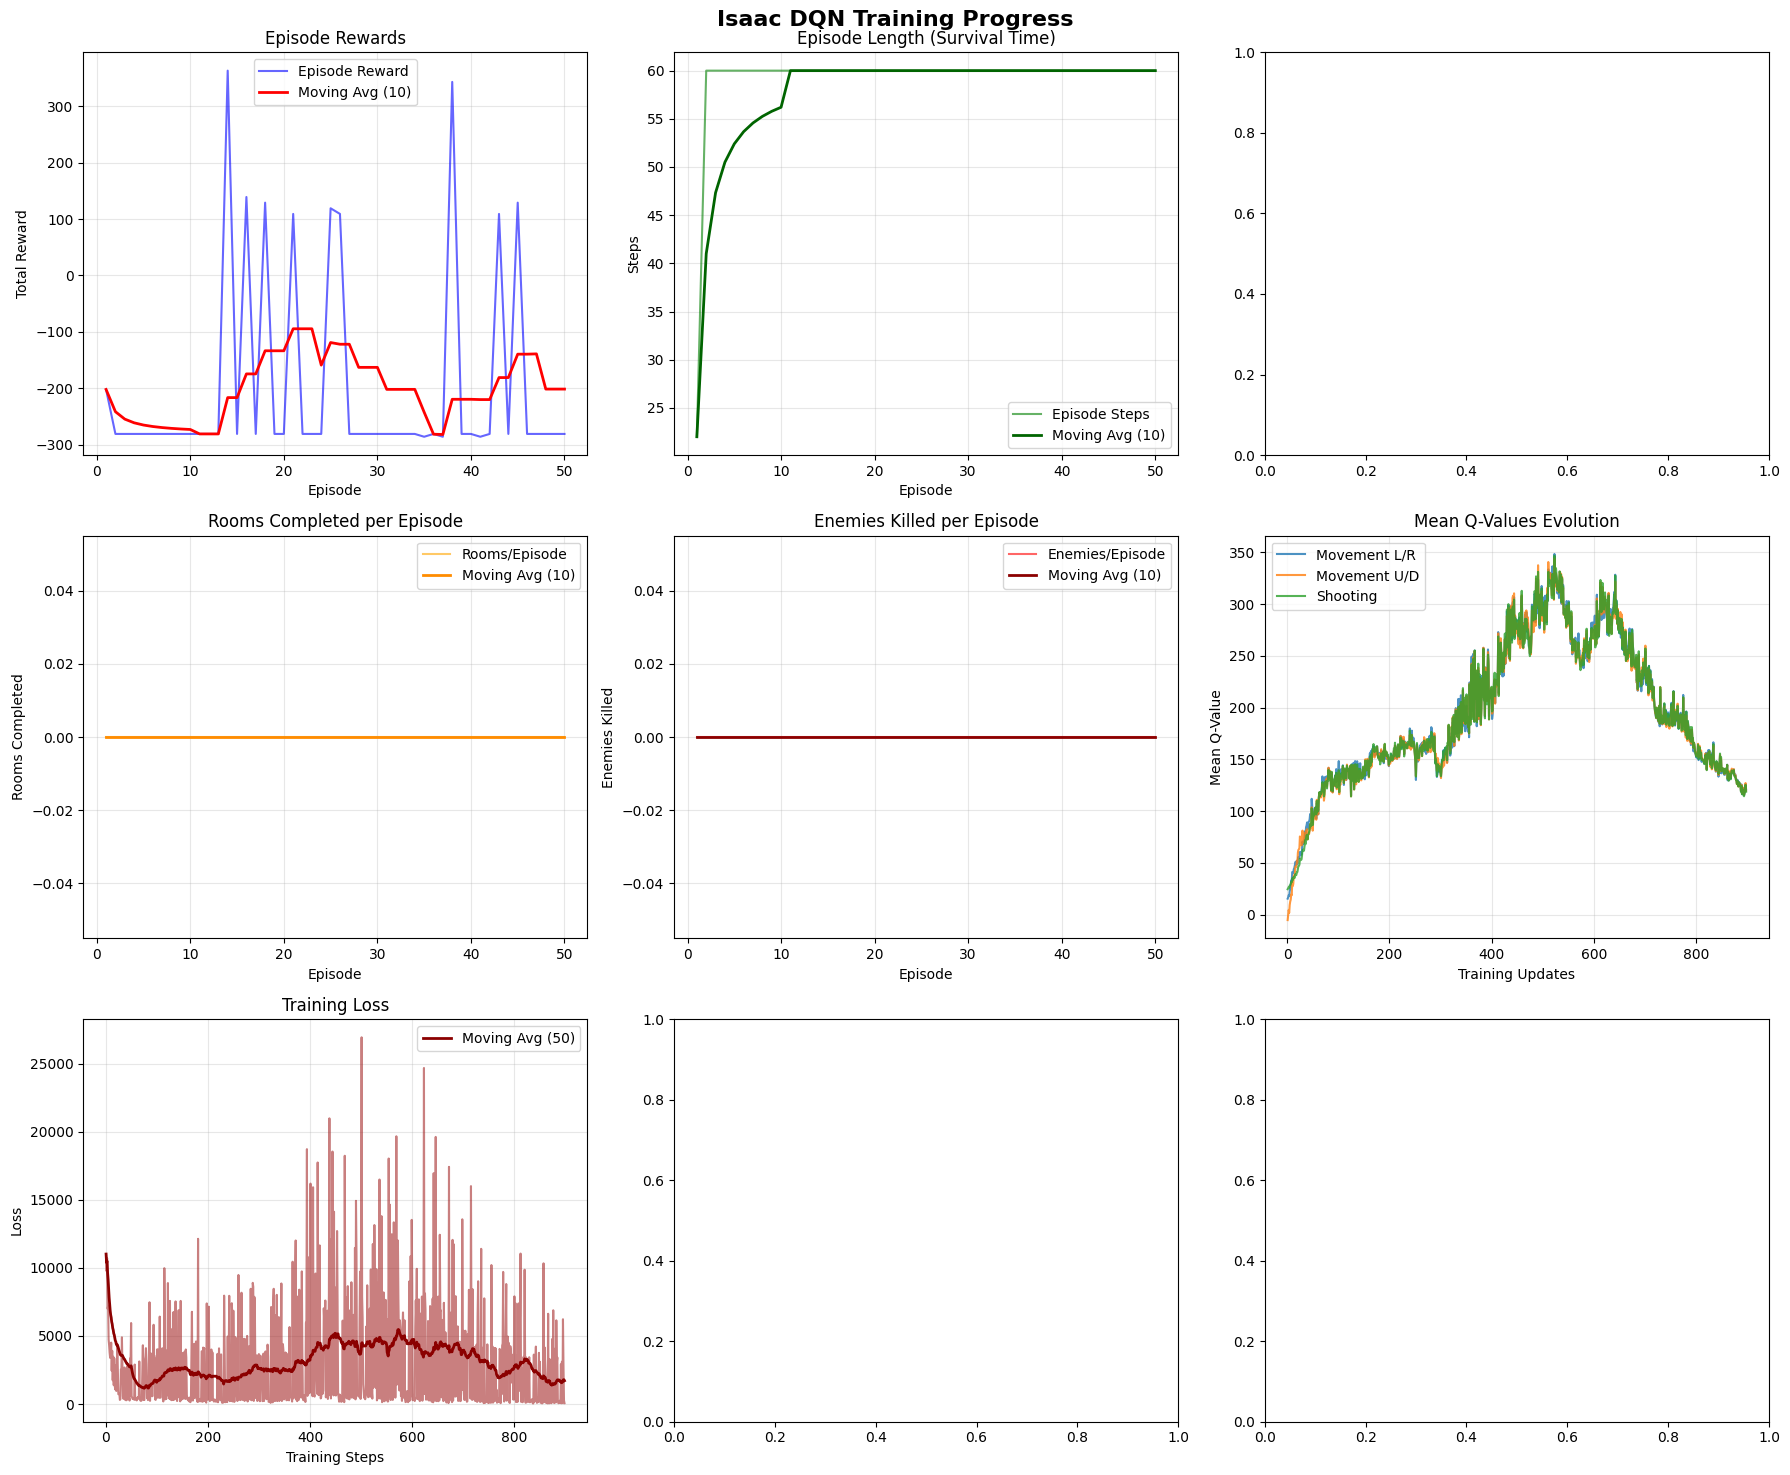

Training progress plots saved to training_progress.png
Training completed


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\erneset\miniconda3\envs\tf\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\erneset\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\erneset\miniconda3\envs\tf\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\erneset\AppData\Local\Temp\ipykernel_13792\1222398433.py", line 173, in environment_thread
  File "C:\Users\erneset\AppData\Local\Temp\ipykernel_13792\1507044663.py", line 236, in reset
ConnectionError: Lost connection during reset


Failed to reconnect after 3 attempts
Model saved successfully to isaac_dqn_model.keras
Epsilon state: current=0.9900, episode=2

Generating training statistics and plots...

TRAINING SUMMARY STATISTICS
Total Episodes: 2
Total Training Time: 7.44 seconds

REWARD STATISTICS:
  Average Reward: -203.30
  Best Reward: -202.20
  Worst Reward: -204.40
  Std Deviation: 1.10

SURVIVAL STATISTICS:
  Average Episode Length: 33.0 steps
  Longest Episode: 44 steps
  Shortest Episode: 22 steps

PROGRESS STATISTICS:
  Total Rooms Completed: 0
  Average Rooms/Episode: 0.00
  Best Rooms in Episode: 0
  Total Enemies Killed: 0
  Average Enemies/Episode: 0.00
  Best Enemies in Episode: 0
Training progress plots saved to training_progress.png
Training completed



Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  100


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57701)
Socket connection closed
Socket connection test successful.

Starting training for 100 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Connection lost, attempting to reconnect...
Socket connection closed
Reconnection attempt 1/3
Environment thread started
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57702)
Training - Episode:1 | Total reward:-202.200 | Steps:22 | Epsilon:0.9950
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, 


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  100


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57376)
Socket connection closed
Socket connection test successful.

Starting training for 100 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57377)
Training - Episode:1 | Total reward:-202.200 | Steps:22 | Epsilon:0.9950
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connecti


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  20


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57002)
Socket connection closed
Socket connection test successful.

Starting training for 20 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started
Python waiting for connection on 127.0.0.1:12345...
Waiting up to 30 seconds for client connection...
Connected to ('127.0.0.1', 57003)
Procesando datos recibidos...
Datos procesados exitosamente
Datos válidos recibidos
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos procesados
Procesando datos recibidos...
Datos


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  20


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Connected to ('127.0.0.1', 55759)
Socket connection closed
Socket connection test successful.

Starting training for 20 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started
Python waiting for connection on 127.0.0.1:12345...
Connected to ('127.0.0.1', 55760)
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No se han recibido datos, reintentando...
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No data received, connection may be closed
No se han recibido datos, rei


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  20


Using new model...
Testing socket connection...
Python waiting for connection on 127.0.0.1:12345...
Error establishing connection: [WinError 10035] A non-blocking socket operation could not be completed immediately
Failed to establish socket connection. Please check if the game/client is running.


Using new model...

Starting training for 100 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started
File agent_output.txt exceeded 1,429,000 bytes and was cleared.

[Training Step 0] Verifying experience replay...
Q-value changes after training:
  Left/Right head: 1.791756
  Up/Down head: 2.463095
  Shooting head: 3.571431
Training - Episode:1 | Total reward:-501.000 | Steps:60 | Epsilon:0.9950
Testing Experience Replay...
Initial buffer size: 107
Training - Episode:2 | Total reward:452.000 | Steps:60 | Epsilon:0.9900
Training - Episode:3 | Total reward:103.900 | Steps:61 | Epsilon:0.9851

[Training Step 50] Verifying experience replay...
Q-value changes after training:
  Left/Right head: 0.159197
  Up/Down head: 0.282385
  Shooting head: 0.471466
Buffer size after 5 seconds: 193
✓ Buffer is being filled
✓ Training steps are happening
✓ Q-values are


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  100


Using new model...

Starting training for 100 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.05)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started

[Training Step 0] Verifying experience replay...
Q-value changes after training:
  Left/Right head: 3.416888
  Up/Down head: 4.922245
  Shooting head: 2.864344
Testing Experience Replay...
Initial buffer size: 196

[Training Step 50] Verifying experience replay...
Q-value changes after training:
  Left/Right head: 1.563792
  Up/Down head: 1.070758
  Shooting head: 1.152739
Training - Episode:1 | Total reward:-228.300 | Steps:283 | Epsilon:0.9950
Buffer size after 5 seconds: 295
✓ Buffer is being filled
✓ Training steps are happening
✓ Q-values are updating
Experience replay test complete.

Training - Episode:2 | Total reward:-286.000 | Steps:60 | Epsilon:0.9900

[Training Step 100] Verifying experience replay...
Q-value changes after training:
  Left


Do you want to load an existing model? (y/n):  n

Select mode:
1. Train the model
2. Use model (inference only)
Enter choice (1/2):  1

Number of episodes (default 100):  200


Using new model...

Starting training for 200 episodes...
Starting multi-threaded training...
Starting epsilon: 1.0000 (decay: 0.005, min: 0.1)
Continuing from episode: 1
Training thread started (training mode)
Environment thread started
Training - Episode:1 | Total reward:-565.900 | Steps:60 | Epsilon:0.9950
Training - Episode:2 | Total reward:-522.900 | Steps:60 | Epsilon:0.9900
Training - Episode:3 | Total reward:-523.000 | Steps:61 | Epsilon:0.9851
Training - Episode:4 | Total reward:79.100 | Steps:60 | Epsilon:0.9801
Training - Episode:5 | Total reward:-522.900 | Steps:60 | Epsilon:0.9752
Training - Episode:6 | Total reward:-523.000 | Steps:61 | Epsilon:0.9704
Training - Episode:7 | Total reward:-521.900 | Steps:60 | Epsilon:0.9655
Training - Episode:8 | Total reward:-522.900 | Steps:60 | Epsilon:0.9607
Training - Episode:9 | Total reward:-523.000 | Steps:61 | Epsilon:0.9559
Training - Episode:10 | Total reward:77.100 | Steps:60 | Epsilon:0.9511
Training - Episode:11 | Total rewar

In [ ]:
import threading
import queue
import time
from collections import deque
import numpy as np
import random
import tensorflow as tf
import os

class ThreadedDQNAgent:
    def __init__(self, env, q_network, q_target_network, optimizer):
        self.env = env
        self.q_network = q_network
        self.q_target_network = q_target_network
        self.optimizer = optimizer
        
        # Threading components
        self.experience_queue = queue.Queue(maxsize=1000)
        
        # Training parameters
        self.gamma = 0.98
        self.batch_size = 30
        self.buffer_size = 5000
        self.buffer = deque(maxlen=self.buffer_size)
        self.update_target_episode = 5
        self.steps_count = 0
        
        # Epsilon parameters (now stored as instance variables)
        self.current_epsilon = 1.0
        self.epsilon_decay = 0.005
        self.epsilon_min = 0.05
        self.episode_count = 0  # Track episodes for epsilon decay
        
        # Control flags
        self.training_active = True
        self.environment_active = True
        self.inference_only = False
        self.lock = threading.Lock()

        # Statistics tracking
        self.stats = TrainingStatistics()
        
        # Global variables that need to be thread-safe
        global balas
        self.balas = balas

    def save_model(self, filepath="isaac_dqn_model.keras"):
        """Save the trained model with epsilon values using TensorFlow's recommended format"""
        try:
            # Save the main network using .keras format
            self.q_network.save(filepath)
        
            # Save the target network
            target_filepath = filepath.replace('.keras', '_target.keras')
            self.q_target_network.save(target_filepath)
        
            # Save additional training parameters including epsilon values
            training_params = {
                'steps_count': self.steps_count,
                'gamma': self.gamma,
                'batch_size': self.batch_size,
                'buffer_size': self.buffer_size,
                'update_target_episode': self.update_target_episode,
                # Epsilon parameters
                'current_epsilon': self.current_epsilon,
                'epsilon_decay': self.epsilon_decay,
                'epsilon_min': self.epsilon_min,
                'episode_count': self.episode_count
            }
        
            import json
            params_filepath = filepath.replace('.keras', '_params.json')
            with open(params_filepath, 'w') as f:
                json.dump(training_params, f, indent=2)
        
            print(f"Model saved successfully to {filepath}")
            print(f"Epsilon state: current={self.current_epsilon:.4f}, episode={self.episode_count}")
        
        except Exception as e:
            print(f"Error saving model: {e}")

    def load_model(self, filepath="isaac_dqn_model.keras"):
        """Load a pre-trained model with epsilon values using TensorFlow's recommended format"""
        try:
            # Ensure .keras extension
            if not filepath.endswith('.keras'):
                filepath += '.keras'
            
            # Check if file exists
            if not os.path.exists(filepath):
                print(f"Model file {filepath} not found.")
                return False
            
            # Load the main network
            self.q_network = tf.keras.models.load_model(filepath)
            print(f"Main network loaded from {filepath}")
        
            # Load the target network
            target_filepath = filepath.replace('.keras', '_target.keras')
            if os.path.exists(target_filepath):
                self.q_target_network = tf.keras.models.load_model(target_filepath)
                print(f"Target network loaded from {target_filepath}")
            else:
                # If target network doesn't exist, copy from main network
                self.q_target_network.set_weights(self.q_network.get_weights())
                print("Target network initialized from main network")
        
            # Load training parameters including epsilon values
            params_filepath = filepath.replace('.keras', '_params.json')
            if os.path.exists(params_filepath):
                import json
                with open(params_filepath, 'r') as f:
                    training_params = json.load(f)
                    
                    # Standard training parameters
                    self.steps_count = training_params.get('steps_count', 0)
                    self.gamma = training_params.get('gamma', 0.995)
                    self.batch_size = training_params.get('batch_size', 30)
                    self.buffer_size = training_params.get('buffer_size', 10000)
                    self.update_target_episode = training_params.get('update_target_episode', 10)
                    
                    # Epsilon parameters
                    self.current_epsilon = training_params.get('current_epsilon', 1.0)
                    self.epsilon_decay = training_params.get('epsilon_decay', 0.05)
                    self.epsilon_min = training_params.get('epsilon_min', 0.1)
                    self.episode_count = training_params.get('episode_count', 0)
                    
                    # Recreate buffer with loaded size
                    self.buffer = deque(maxlen=self.buffer_size)
                
                print(f"Training parameters loaded from {params_filepath}")
                print(f"Epsilon state restored: current={self.current_epsilon:.4f}, episode={self.episode_count}")
            else:
                print("No training parameters file found, using defaults")
                # Reset epsilon values to defaults
                self.current_epsilon = 1.0
                self.epsilon_decay = 0.05
                self.epsilon_min = 0.1
                self.episode_count = 0
        
            print(f"Model loaded successfully!")
            return True
        
        except Exception as e:
            print(f"Error loading model: {e}")
            return False

    def environment_thread(self, epsilon, epsilon_decay, epsilon_min, num_episodes):
        """Thread for environment interaction with epsilon state management"""
        
        # Use loaded epsilon values if available, otherwise use passed parameters
        current_epsilon = self.current_epsilon if hasattr(self, 'current_epsilon') else epsilon
        
        # Start episode numbering from where we left off
        start_episode = self.episode_count + 1
        end_episode = self.episode_count + num_episodes
        episode_max_steps = 0
        epsilon_growth_threshold = 0

        for episode in range(start_episode, end_episode + 1):
            if not self.environment_active:
                break

            # Connection debugging (optional)
            if debug_config.enabled and debug_config.show_connection_debug:
                print(f"\n=== Connection Debug - Episode {episode} ===")
                print(f"Connection status: {self.env.connected}")

            # Ensure stable connection at start of each episode
            if not self.env.ensure_connection():
                print(f"Failed to establish connection for episode {episode}, skipping...")
                continue
                
            # Start episode statistics
            self.stats.start_episode()
            
            state = self.env.reset()
            state_action = state[:37]
            done = False
            total_reward = 0
            steps = 0
            total_rooms_completed = 0
            total_enemies_killed = 0
            
            while not done and self.environment_active:
                try:
                    # Get action from epsilon-greedy policy
                    # Use epsilon=0 for inference mode (always exploit)
                    action_epsilon = 0.0 if self.inference_only else current_epsilon

                    action = epsilon_greedy(np.array([state_action]), action_epsilon, self.q_network)
                    
                    # Execute action in environment
                    mov_left_right, mov_up_down, shoot_direction = get_mov_shoot_actions(action)
                    
                    # Send action via socket instead of writing to file
                    try:
                        success = self.env.send_action(mov_left_right, mov_up_down, shoot_direction)
                        if not success:
                            if debug_config.enabled and debug_config.show_connection_debug:
                                print("Failed to send action via socket")
                            continue
                    except Exception as e:
                        if debug_config.enabled and debug_config.show_connection_debug:
                            print(f"Error sending action via socket: {e}")
                        continue
                    
                    # Get next state from environment
                    next_state = self.env.step()
                    next_state_action = next_state[:37]
                    
                    # Calculate reward with statistics
                    reward, truncated, rooms_completed, enemies_killed = calculate_reward(
                        next_state, state, self.stats if not self.inference_only else None
                    )
                    done = truncated
                    steps += 1
                    
                    # Track episode progress
                    total_rooms_completed = max(total_rooms_completed, rooms_completed)
                    total_enemies_killed += enemies_killed
                    
                    # Only add experience to queue if we're training
                    if not self.inference_only:
                        # Create experience tuple
                        experience = (
                            np.array([state_action]), 
                            action, 
                            reward, 
                            np.array([next_state_action]), 
                            done
                        )
                        
                        # Add experience to queue for training thread
                        try:
                            self.experience_queue.put(experience, timeout=0.1)
                        except queue.Full:
                            # Remove oldest experience and add new one
                            try:
                                self.experience_queue.get_nowait()
                                self.experience_queue.put(experience, timeout=0.1)
                            except queue.Empty:
                                pass
                    
                    total_reward += reward
                    state = next_state
                    state_action = next_state_action
                    
                except Exception as e:
                    if debug_config.enabled and debug_config.show_connection_debug:
                        print(f"Error in environment thread: {e}")
                    time.sleep(0.1)
                    continue
            
            if episode_max_steps < steps:
                episode_max_steps = steps

            # Update epsilon only if training
            if not self.inference_only:
                current_epsilon = max(self.epsilon_min, (1 - self.epsilon_decay) * current_epsilon)
                # Update instance variables
                self.current_epsilon = current_epsilon
                self.episode_count = episode

            self.stats.end_episode(
                total_reward, steps, current_epsilon, 
                total_rooms_completed, total_enemies_killed
            )

            # Conditional debugging every 10 episodes
            if episode % 10 == 0 and debug_config.enabled:
                print(f"\n=== EPISODE {episode} DEBUGGING ===")
                if debug_config.show_experience_analysis:
                    self.analyze_experience_quality()
                if debug_config.show_target_network_verification:
                    self.verify_target_network_updates()
            
            mode = "Inference" if self.inference_only else "Training"
            epsilon_info = f" | Epsilon:{current_epsilon:.4f}" if not self.inference_only else ""
            print(f"{mode} - Episode:{episode} | Total reward:{total_reward:.3f} | Steps:{steps}{epsilon_info}")
        

    def start_training(self, num_episodes=100, inference_only=False):
        """Start both threads with epsilon state management"""
        self.inference_only = inference_only
        
        # Training parameters (these will be overridden by loaded values if available)
        epsilon = self.current_epsilon if hasattr(self, 'current_epsilon') else 1.0
        epsilon_decay = self.epsilon_decay if hasattr(self, 'epsilon_decay') else 0.05
        epsilon_min = self.epsilon_min if hasattr(self, 'epsilon_min') else 0.1
        
        mode = "inference" if inference_only else "training"
        print(f"Starting multi-threaded {mode}...")
        
        if not inference_only:
            print(f"Starting epsilon: {epsilon:.4f} (decay: {epsilon_decay}, min: {epsilon_min})")
            print(f"Continuing from episode: {self.episode_count + 1}")
        
        try:
            # Start training thread (will skip training if inference_only=True)
            training_thread = threading.Thread(target=self.training_thread, daemon=True)
            training_thread.start()
            print(f"Training thread started ({'inference mode' if inference_only else 'training mode'})")
            
            # Start environment thread
            env_thread = threading.Thread(
                target=self.environment_thread, 
                args=(epsilon, epsilon_decay, epsilon_min, num_episodes),
                daemon=True
            )
            env_thread.start()
            print("Environment thread started")
            
            # Wait for environment thread to complete
            env_thread.join()
            
        except KeyboardInterrupt:
            print(f"{mode.capitalize()} interrupted by user")
        except Exception as e:
            print(f"Error in start_{mode}: {e}")
        finally:
            # Stop threads
            self.environment_active = False
            self.training_active = False
            
            # Wait for training thread to finish
            if 'training_thread' in locals():
                training_thread.join(timeout=5)
            
            # Save model and generate statistics if we were training
            if not inference_only:
                self.save_model()
                
                # Generate comprehensive statistics
                print("\nGenerating training statistics and plots...")
                self.stats.print_summary()
                self.stats.plot_training_progress()
            
            print(f"{mode.capitalize()} completed")

    def training_thread(self):
        """Thread for neural network training with debugging"""
        training_count = 0
        last_debug_time = time.time()
        
        while self.training_active:
            try:
                # Skip training if in inference mode
                if self.inference_only:
                    time.sleep(0.1)
                    continue
                
                # Collect experiences from queue
                experiences_batch = []
                
                # Try to get experiences from queue
                for _ in range(min(self.batch_size, self.experience_queue.qsize())):
                    try:
                        experience = self.experience_queue.get(timeout=0.1)
                        experiences_batch.append(experience)
                        self.experience_queue.task_done()
                    except queue.Empty:
                        break
                
                # Add experiences to buffer
                experiences_added = 0
                for experience in experiences_batch:
                    self.buffer.append(experience)
                    experiences_added += 1
                
                # Train if we have enough experiences
                if len(self.buffer) >= self.batch_size:
                    # Conditional verification every 50 steps
                    verify_training = (training_count % 50 == 0) and debug_config.enabled and debug_config.show_q_learning_verification
                    
                    if verify_training:
                        print(f"\n[Training Step {training_count}] Verifying experience replay...")
                        is_learning = self.verify_q_learning_updates()
                        if not is_learning:
                            print("WARNING: Q-values not changing! Training may be stuck.")
                    else:
                        self.train_network()
                    
                    training_count += 1
                
                # Conditional debug info every 30 seconds
                current_time = time.time()
                if (current_time - last_debug_time > 30) and debug_config.enabled and debug_config.show_experience_replay_debug:
                    self.debug_experience_replay()
                    last_debug_time = current_time
                
                # Small delay to prevent excessive CPU usage
                time.sleep(0.1)
                
            except Exception as e:
                print(f"Error in training thread: {e}")
                import traceback
                traceback.print_exc()
                time.sleep(0.1)

    def train_network(self):
        """Train the neural network with experience replay"""
        try:
            if len(self.buffer) <= self.batch_size:
                return
            
            # Fast sampling using indices
            indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
    
            # Pre-allocate arrays
            states = np.zeros((self.batch_size, 37), dtype=np.float32)
            next_states = np.zeros((self.batch_size, 37), dtype=np.float32)
            actions = np.zeros((self.batch_size, 3), dtype=np.int32)
            rewards = np.zeros(self.batch_size, dtype=np.float32)
            dones = np.zeros(self.batch_size, dtype=bool)
    
            # Fill arrays efficiently
            for i, idx in enumerate(indices):
                exp = self.buffer[idx]
                states[i] = exp[0].flatten()[:37]  # Ensure correct shape
                actions[i] = exp[1]
                rewards[i] = exp[2]
                next_states[i] = exp[3].flatten()[:37]
                dones[i] = exp[4]
            
            # Get current Q-values for all heads
            current_q_values = self.q_network(states)
            current_q_lr = current_q_values[0].numpy()
            current_q_ud = current_q_values[1].numpy()
            current_q_shoot = current_q_values[2].numpy()

            # Track Q-values for statistics (ADD THIS)
            if not self.inference_only and len(current_q_lr) > 0:
                self.stats.add_q_values(current_q_lr.flatten(), current_q_ud.flatten(), current_q_shoot.flatten())
        
            
            # Get next Q-values for all heads
            next_q_values = self.q_target_network(next_states)
            next_q_lr = next_q_values[0].numpy()
            next_q_ud = next_q_values[1].numpy()
            next_q_shoot = next_q_values[2].numpy()
            
            # Calculate targets for each head
            q_targets_lr = current_q_lr.copy()
            q_targets_ud = current_q_ud.copy()
            q_targets_shoot = current_q_shoot.copy()
            
            for i in range(self.batch_size):
                if dones[i]:
                    target = rewards[i]
                else:
                    max_next_q_lr = np.max(next_q_lr[i])
                    max_next_q_ud = np.max(next_q_ud[i])
                    max_next_q_shoot = np.max(next_q_shoot[i])
                    target = rewards[i] + self.gamma * (max_next_q_lr + max_next_q_ud + max_next_q_shoot) / 3
                
                mov_lr_action, mov_ud_action, shoot_action = actions[i]
                q_targets_lr[i][mov_lr_action] = target
                q_targets_ud[i][mov_ud_action] = target
                q_targets_shoot[i][shoot_action] = target
            
            # Convert to tensors
            q_targets_lr = tf.convert_to_tensor(q_targets_lr, dtype=tf.float32)
            q_targets_ud = tf.convert_to_tensor(q_targets_ud, dtype=tf.float32)
            q_targets_shoot = tf.convert_to_tensor(q_targets_shoot, dtype=tf.float32)

            if not self.inference_only and len(current_q_lr) > 0:
                self.stats.add_q_values(current_q_lr.flatten(), current_q_ud.flatten(), current_q_shoot.flatten())

            # Update parameters
            total_loss = update_parameters(states, q_targets_lr, q_targets_ud, q_targets_shoot, self.q_network, self.optimizer)

            # Track loss
            if not self.inference_only:
                self.stats.add_loss(float(total_loss.numpy()))
            
            # Update target network periodically
            self.steps_count += 1
            if self.steps_count % self.update_target_episode == 0:
                self.q_target_network.set_weights(self.q_network.get_weights())
                if not self.inference_only:
                    self.stats.target_updates.append(self.steps_count)
                
        except Exception as e:
            print(f"Error in train_network: {e}")

    def analyze_experience_quality(self):
        """Analyze the quality and diversity of experiences in buffer"""
        if not debug_config.enabled or not debug_config.show_experience_analysis:
            return
            
        if len(self.buffer) < 100:
            print("Not enough experiences to analyze")
            return
        
        print(f"\n=== EXPERIENCE QUALITY ANALYSIS ===")
        
        # Extract data from buffer
        states = []
        actions = []
        rewards = []
        dones = []
        
        sample_size = min(1000, len(self.buffer))
        sampled_experiences = random.sample(list(self.buffer), sample_size)
        
        for exp in sampled_experiences:
            states.append(exp[0].flatten()[:37])
            actions.append(exp[1])
            rewards.append(exp[2])
            dones.append(exp[4])
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        
        # 1. Action diversity
        action_counts = {}
        for action in actions:
            key = tuple(action)
            action_counts[key] = action_counts.get(key, 0) + 1
        
        print(f"Action diversity: {len(action_counts)} unique action combinations")
        print(f"Most common actions:")
        sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)
        for action, count in sorted_actions[:5]:
            percentage = (count / len(actions)) * 100
            print(f"  {action}: {count} times ({percentage:.1f}%)")
        
        # 2. Reward distribution
        print(f"\nReward distribution:")
        print(f"  Mean: {np.mean(rewards):.3f}")
        print(f"  Std: {np.std(rewards):.3f}")
        print(f"  Range: [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
        
        # Count reward types
        reward_types = {}
        for r in rewards:
            rounded = round(r, 1)
            reward_types[rounded] = reward_types.get(rounded, 0) + 1
        
        print(f"  Most common rewards:")
        sorted_rewards = sorted(reward_types.items(), key=lambda x: x[1], reverse=True)
        for reward, count in sorted_rewards[:5]:
            percentage = (count / len(rewards)) * 100
            print(f"    {reward}: {count} times ({percentage:.1f}%)")
        
        # 3. State diversity (check if agent is stuck)
        player_positions = states[:, [28, 29]]  # Player x, y positions
        unique_positions = len(np.unique(player_positions, axis=0))
        print(f"\nState diversity:")
        print(f"  Unique player positions: {unique_positions}")
        
        # 4. Episode completion rate
        done_rate = np.mean(dones) * 100
        print(f"  Episode completion rate: {done_rate:.1f}%")
        
        # 5. Check for pathological patterns
        consecutive_same_actions = 0
        max_consecutive = 0
        for i in range(1, len(actions)):
            if np.array_equal(actions[i], actions[i-1]):
                consecutive_same_actions += 1
                max_consecutive = max(max_consecutive, consecutive_same_actions + 1)
            else:
                consecutive_same_actions = 0
        
        print(f"  Max consecutive identical actions: {max_consecutive}")
        if max_consecutive > 20:
            print("  WARNING: Agent may be stuck in repetitive behavior!")
        
        print("=" * 40)

    def verify_target_network_updates(self):
        """Check if target network is being updated correctly"""
        # Get weights from both networks

        if not debug_config.enabled or not debug_config.show_target_network_verification:
            return False

        main_weights = self.q_network.get_weights()
        target_weights = self.q_target_network.get_weights()
        
        # Check if they're identical (after update) or different (before update)
        weights_identical = True
        total_difference = 0
        
        for main_w, target_w in zip(main_weights, target_weights):
            diff = np.mean(np.abs(main_w - target_w))
            total_difference += diff
            if diff > 1e-8:
                weights_identical = False
        
        print(f"Target network status:")
        print(f"  Weights identical to main: {weights_identical}")
        print(f"  Average weight difference: {total_difference:.8f}")
        print(f"  Steps since last update: {self.steps_count % self.update_target_episode}")
        
        return not weights_identical  # Should be False right after update

    def debug_experience_replay(self):
        """Debug information about experience replay"""
        if not debug_config.enabled or not debug_config.show_experience_replay_debug:
            return
        print(f"\n=== EXPERIENCE REPLAY DEBUG ===")
        print(f"Buffer size: {len(self.buffer)}/{self.buffer_size}")
        print(f"Experience queue size: {self.experience_queue.qsize()}")
        print(f"Training steps: {self.steps_count}")
        
        if len(self.buffer) > 0:
            # Sample a few experiences to check format
            sample_exp = self.buffer[0]
            print(f"Experience format check:")
            print(f"  State shape: {sample_exp[0].shape}")
            print(f"  Action: {sample_exp[1]}")
            print(f"  Reward: {sample_exp[2]}")
            print(f"  Next state shape: {sample_exp[3].shape}")
            print(f"  Done: {sample_exp[4]}")
            
            # Check reward distribution
            rewards = [exp[2] for exp in list(self.buffer)[-100:]]  # Last 100 rewards
            print(f"Recent reward stats:")
            print(f"  Mean: {np.mean(rewards):.3f}")
            print(f"  Std: {np.std(rewards):.3f}")
            print(f"  Min: {np.min(rewards):.3f}")
            print(f"  Max: {np.max(rewards):.3f}")
        print("=" * 32)

    def verify_q_learning_updates(self):
        """Verify Q-values are actually changing"""
        if not debug_config.enabled or not debug_config.show_q_learning_verification:
            return True
            
        if len(self.buffer) < self.batch_size:
            return True
        
        # Get Q-values before training
        sample_state = np.array([self.buffer[0][0].flatten()[:37]])
        q_before = self.q_network(sample_state)
        q_lr_before = q_before[0][0].numpy()
        q_ud_before = q_before[1][0].numpy()
        q_shoot_before = q_before[2][0].numpy()
        
        # Train one step
        self.train_network()
        
        # Get Q-values after training
        q_after = self.q_network(sample_state)
        q_lr_after = q_after[0][0].numpy()
        q_ud_after = q_after[1][0].numpy()
        q_shoot_after = q_after[2][0].numpy()
        
        # Check if values changed
        lr_change = np.mean(np.abs(q_lr_after - q_lr_before))
        ud_change = np.mean(np.abs(q_ud_after - q_ud_before))
        shoot_change = np.mean(np.abs(q_shoot_after - q_shoot_before))
        
        print(f"Q-value changes after training:")
        print(f"  Left/Right head: {lr_change:.6f}")
        print(f"  Up/Down head: {ud_change:.6f}")
        print(f"  Shooting head: {shoot_change:.6f}")
        
        return lr_change > 1e-6 or ud_change > 1e-6 or shoot_change > 1e-6

def test_experience_replay_simple(agent):
    """Simple test to verify experience replay is working"""

    if not debug_config.enabled:
        return
    
    print("Testing Experience Replay...")
    
    # 1. Check if buffer is being filled
    initial_buffer_size = len(agent.buffer)
    print(f"Initial buffer size: {initial_buffer_size}")
    
    # Wait a bit for experiences to accumulate
    time.sleep(10)
    new_buffer_size = len(agent.buffer)
    print(f"Buffer size after 5 seconds: {new_buffer_size}")
    
    if new_buffer_size > initial_buffer_size:
        print("✓ Buffer is being filled")
    else:
        print("✗ Buffer not filling - check experience collection")
    
    # 2. Check if training is happening
    if len(agent.buffer) >= agent.batch_size:
        initial_steps = agent.steps_count
        time.sleep(10)
        new_steps = agent.steps_count
        
        if new_steps > initial_steps:
            print("✓ Training steps are happening")
        else:
            print("✗ No training steps - check training thread")
    
    # 3. Quick Q-value change test
    if len(agent.buffer) >= agent.batch_size:
        sample_state = np.array([agent.buffer[0][0].flatten()[:37]])
        q_before = agent.q_network(sample_state)
        
        # Trigger training
        agent.train_network()
        
        q_after = agent.q_network(sample_state)
        
        # Check if any Q-values changed
        changed = False
        for i in range(3):  # 3 heads
            if not np.allclose(q_before[i].numpy(), q_after[i].numpy(), atol=1e-6):
                changed = True
                break
        
        if changed:
            print("✓ Q-values are updating")
        else:
            print("✗ Q-values not changing - check loss calculation")
    
    print("Experience replay test complete.\n")

def get_user_choice():
    """Get user choice for model loading and mode selection"""
    print("\n" + "="*50)
    print("Isaac DQN Agent Setup")
    print("="*50)
    
    # Ask about loading existing model
    while True:
        load_choice = input("\nDo you want to load an existing model? (y/n): ").lower().strip()
        if load_choice in ['y', 'yes', 'n', 'no']:
            break
        print("Please enter 'y' for yes or 'n' for no.")
    
    load_existing = load_choice in ['y', 'yes']
    
    # Ask about training vs inference
    while True:
        mode_choice = input("\nSelect mode:\n1. Train the model\n2. Use model (inference only)\nEnter choice (1/2): ").strip()
        if mode_choice in ['1', '2']:
            break
        print("Please enter '1' for training or '2' for inference.")
    
    train_mode = mode_choice == '1'
    
    # Get number of episodes if training
    num_episodes = 100  # default
    if train_mode:
        while True:
            try:
                episodes_input = input(f"\nNumber of episodes (default {num_episodes}): ").strip()
                if episodes_input == "":
                    break
                num_episodes = int(episodes_input)
                if num_episodes > 0:
                    break
                else:
                    print("Please enter a positive number.")
            except ValueError:
                print("Please enter a valid number.")
    
    return load_existing, train_mode, num_episodes


# Main execution with user interaction
def main():

    debug_config.configure()

    # Get user preferences
    load_existing, train_mode, num_episodes = get_user_choice()
    
    # Create agent
    agent = ThreadedDQNAgent(env, q_network, q_target_network, optimizer)
    
    # Load existing model if requested
    if load_existing:
        model_path = input("\nEnter model path (default 'isaac_dqn_model'): ").strip()
        if model_path == "":
            model_path = "isaac_dqn_model"
        
        if not agent.load_model(model_path):
            print("Failed to load model. Creating new model...")
            load_existing = False
    
    if not load_existing:
        print("Using new model...")
    
    # Test socket connection before starting
    print("Testing socket connection...")
    try:
        if not env.connect():
            print("Failed to establish socket connection. Please check if the game/client is running.")
            return
        env.disconnect()  # Close test connection
        print("Socket connection test successful.")
    except Exception as e:
        print(f"Socket connection test failed: {e}")
        return
    
    # Start training or inference
    if train_mode:
        print(f"\nStarting training for {num_episodes} episodes...")
        
        # Start training in background
        import threading
        training_thread = threading.Thread(
            target=lambda: agent.start_training(num_episodes=num_episodes, inference_only=False)
        )
        training_thread.start()
        
        # Conditional experience replay test
        if debug_config.enabled:
            time.sleep(30)
            test_experience_replay_simple(agent)
        
        # Wait for training to complete
        training_thread.join()
    else:
        print(f"\nStarting inference mode for {num_episodes} episodes...")
        agent.start_training(num_episodes=num_episodes, inference_only=True)

# Run the main function
main()